**Collecte des données**

In [2]:
# Collecte et préparation des séries : indices + VIX (2010-2025)
from pathlib import Path
import yfinance as yf
import pandas as pd
import numpy as np
import time

# Tickes: S&P500 + 5 indices choisis (HSI pour Hong Kong)
tickers = ["^GSPC", "^GDAXI", "^N225", "^BVSP", "^NSEI", "^HSI"]
start = "2010-01-01"
end = "2025-12-31"

# Détecter automatiquement la racine du dépôt en cherchant l'énoncé
cwd = Path.cwd()
repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / 'Enonce_EtudeCas1.md').exists():
        repo_root = p
        break
if repo_root is None:
    repo_root = cwd
data_dir = repo_root / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
print('Data directory:', data_dir)

# Télécharger chaque série d'indice et créer un fichier avec prix + rendements
all_prices = []
all_returns = []

for t in tickers:
    print('Downloading', t)
    try:
        df = yf.download(t, start=start, end=end, progress=False, auto_adjust=True)
    except Exception as e:
        print('Download error for', t, e)
        continue
    if df is None or df.empty:
        print('Warning: no data for', t)
        continue
    
    # Préférer 'Adj Close' si disponible
    if 'Adj Close' in df.columns:
        prices = df['Adj Close'].copy()
    elif 'Close' in df.columns:
        prices = df['Close'].copy()
    else:
        prices = df.iloc[:, 0].copy()
    
    # S'assurer que les prix sont en float et triés
    prices = prices.astype(float).sort_index()
    
    # Calculer les rendements logarithmiques
    returns = np.log(prices).diff()
    
    # Créer un DataFrame avec prix et rendements pour cet indice
    ticker_clean = t.replace('^', '').replace('.', '_')
    
    # Créer le DataFrame en utilisant l'index des prix
    combined_df = pd.DataFrame(index=prices.index)
    combined_df['Price'] = prices
    combined_df['Returns'] = returns
    combined_df.index.name = 'Date'
    
    # Sauvegarder le fichier combiné pour cet indice
    fname = f"{ticker_clean}.csv"
    path = data_dir / fname
    combined_df.to_csv(path)
    print(f'Saved {ticker_clean}: {path} (rows={len(combined_df)})')
    
    # Garder pour les fichiers merged séparés
    prices.name = ticker_clean
    returns_clean = returns.dropna()
    returns_clean.name = ticker_clean
    all_prices.append(prices)
    all_returns.append(returns_clean)
    
    time.sleep(1.0)

# Créer les fichiers merged séparés : prix ET rendements
if all_prices:
    # 1. Fichier merged PRIX seulement
    merged_prices = pd.concat(all_prices, axis=1).sort_index()
    merged_prices_path = data_dir / 'merged_prices.csv'
    merged_prices.to_csv(merged_prices_path)
    print(f'Merged PRICES saved: {merged_prices_path}')
    
    # 2. Fichier merged RENDEMENTS seulement (inner join pour dates communes)
    merged_returns = pd.concat(all_returns, axis=1, join="inner").sort_index()
    merged_returns_path = data_dir / 'merged_returns.csv'
    merged_returns.to_csv(merged_returns_path)
    print(f'Merged RETURNS saved: {merged_returns_path}')

# Télécharger et traiter VIX de la même manière
print('Downloading ^VIX')
try:
    vix_df = yf.download('^VIX', start=start, end=end, progress=False, auto_adjust=True)
    if vix_df is not None and not vix_df.empty:
        if 'Adj Close' in vix_df.columns:
            vix_prices = vix_df['Adj Close'].copy()
        elif 'Close' in vix_df.columns:
            vix_prices = vix_df['Close'].copy()
        else:
            vix_prices = vix_df.iloc[:, 0].copy()
        
        # S'assurer que VIX est en float et trié
        vix_prices = vix_prices.astype(float).sort_index()
        
        # Calculer rendements VIX
        vix_returns = np.log(vix_prices).diff()
        
        # Fichier VIX individuel
        vix_combined = pd.DataFrame(index=vix_prices.index)
        vix_combined['Price'] = vix_prices
        vix_combined['Returns'] = vix_returns
        vix_combined.index.name = 'Date'
        vix_path = data_dir / 'VIX.csv'
        vix_combined.to_csv(vix_path)
        print(f'Saved VIX: {vix_path} (rows={len(vix_combined)})')
        
        # Ajouter VIX au fichier merged PRIX
        if merged_prices_path.exists():
            merged_prices = pd.read_csv(merged_prices_path, index_col=0, parse_dates=True)
            merged_prices['VIX'] = vix_prices.reindex(merged_prices.index)
            merged_prices.to_csv(merged_prices_path)
            print(f'VIX added to merged prices: {merged_prices_path}')
        
        # Ajouter VIX au fichier merged RENDEMENTS (alignement sur dates communes)
        if merged_returns_path.exists():
            merged_returns = pd.read_csv(merged_returns_path, index_col=0, parse_dates=True)
            # Aligner VIX sur les dates communes des rendements
            vix_returns_aligned = vix_returns.reindex(merged_returns.index)
            merged_returns['VIX'] = vix_returns_aligned
            merged_returns.to_csv(merged_returns_path)
            print(f'VIX added to merged returns: {merged_returns_path}')
            
            # Créer aussi un fichier avec VIX niveaux pour régression corr~log(VIX)
            vix_levels_path = data_dir / 'vix_levels_aligned.csv'
            vix_levels_aligned = vix_prices.reindex(merged_returns.index)
            vix_levels_aligned.to_csv(vix_levels_path)
            print(f'VIX levels (for regression) saved: {vix_levels_path}')
    else:
        print('Warning: no VIX data downloaded')
except Exception as e:
    print('VIX download error:', e)

print("\n=== Fichiers créés ===")
print("Structure: Chaque indice = 1 fichier (Price + Returns)")
print("Fichier merged PRIX:", merged_prices_path.name if 'merged_prices_path' in locals() else "Non créé")
print("Fichier merged RENDEMENTS:", merged_returns_path.name if 'merged_returns_path' in locals() else "Non créé")
print("VIX niveaux alignés:", 'vix_levels_aligned.csv' if 'vix_levels_path' in locals() else "Non créé")
if data_dir.exists():
    csv_files = list(data_dir.glob('*.csv'))
    print(f"Total fichiers CSV: {len(csv_files)}")
    for f in sorted(csv_files):
        print(f"  - {f.name}")

Data directory: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data
Saved GSPC: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GSPC.csv (rows=3985)
Saved GSPC: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GSPC.csv (rows=3985)
Saved GDAXI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GDAXI.csv (rows=4022)
Saved GDAXI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GDAXI.csv (rows=4022)
Saved N225: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\N225.csv (rows=3874)
Saved N225: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\N225.csv (rows=3874)
Saved BVSP: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\BVSP.csv (rows=3928)
Saved BVSP: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\

**2.1.1 - Corrélations mobiles 126 jours**

Données: 3258 observations, 6 indices
Période: 2010-01-05 à 2025-10-31

Calcul corrélations mobiles avec ^GSPC...
Résultat: 3133 observations de corrélations

=== Statistiques des corrélations ===
         ^GDAXI     ^N225     ^BVSP     ^NSEI      ^HSI
count  3133.000  3133.000  3133.000  3133.000  3133.000
mean      0.550     0.163     0.482     0.230     0.189
std       0.142     0.121     0.179     0.119     0.118
min       0.091    -0.141     0.021    -0.042    -0.092
25%       0.486     0.083     0.367     0.145     0.093
50%       0.542     0.153     0.452     0.229     0.192
75%       0.669     0.254     0.582     0.304     0.267
max       0.839     0.607     0.910     0.627     0.472


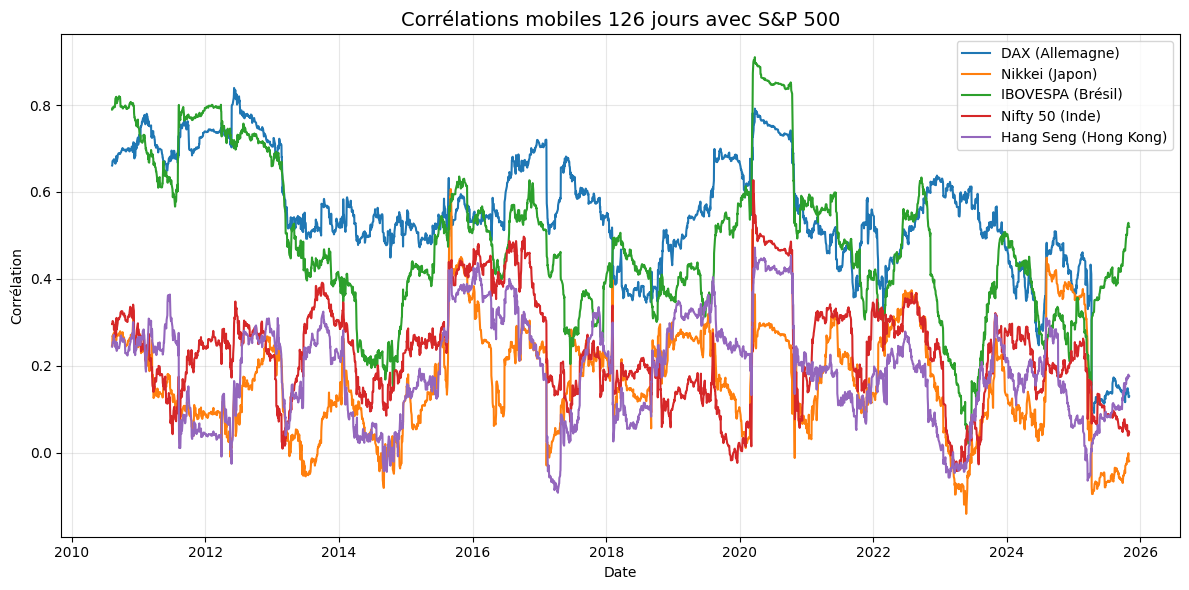


=== Corrélations moyennes ===
DAX (Allemagne)     : 0.550
IBOVESPA (Brésil)   : 0.482
Nifty 50 (Inde)     : 0.230
Hang Seng (Hong Kong): 0.189
Nikkei (Japon)      : 0.163

Fichier sauvegardé: correlations_126days.csv


In [3]:
# 2.1.1 - Calcul des corrélations mobiles 126 jours entre S&P 500 et indices internationaux
import numpy as np
import matplotlib.pyplot as plt

# Charger les données de rendements
returns = pd.read_csv(data_dir / 'merged_returns.csv', index_col=0, parse_dates=True)
stock_returns = returns.drop('VIX', axis=1) if 'VIX' in returns.columns else returns.copy()

print(f"Données: {stock_returns.shape[0]} observations, {stock_returns.shape[1]} indices")
print(f"Période: {stock_returns.index[0].date()} à {stock_returns.index[-1].date()}")

# Identifier S&P 500 et calculer corrélations mobiles 126 jours
sp500_col = [col for col in stock_returns.columns if 'GSPC' in col][0]
sp500_returns = stock_returns[sp500_col]
rolling_window = 126

print(f"\nCalcul corrélations mobiles avec {sp500_col}...")
correlations = {}
for col in stock_returns.columns:
    if col != sp500_col:
        correlations[col] = stock_returns[col].rolling(window=rolling_window).corr(sp500_returns)

# Créer DataFrame et nettoyer
corr_df = pd.DataFrame(correlations).dropna()
print(f"Résultat: {corr_df.shape[0]} observations de corrélations")

# Sauvegarder
corr_path = data_dir / 'correlations_126days.csv'
corr_df.to_csv(corr_path)

# Statistiques descriptives
print(f"\n=== Statistiques des corrélations ===")
print(corr_df.describe().round(3))

# Graphique simplifié
markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

plt.figure(figsize=(12, 6))
for col in corr_df.columns:
    plt.plot(corr_df.index, corr_df[col], label=markets.get(col, col), linewidth=1.5)

plt.title('Corrélations mobiles 126 jours avec S&P 500', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Corrélation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Résumé par marché
print(f"\n=== Corrélations moyennes ===")
for market, corr in corr_df.mean().sort_values(ascending=False).items():
    print(f"{markets.get(market, market):20}: {corr:.3f}")

print(f"\nFichier sauvegardé: {corr_path.name}")

**2.1.2 - Tests de stationnarité (ADF et DF-GLS)**

In [6]:
# 2.1.2 - Tests de stationnarité robustes (ADF + Phillips-Perron + KPSS)
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd

# Charger les corrélations calculées précédemment
corr_df = pd.read_csv(data_dir / 'correlations_126days.csv', index_col=0, parse_dates=True)

print("=== Tests de stationnarité des corrélations (Triple validation) ===")
print("\nH0 ADF: Série non-stationnaire (racine unitaire)")
print("H0 Phillips-Perron: Série non-stationnaire (racine unitaire)")
print("H0 KPSS: Série stationnaire")
print("Seuil significativité: 5%\n")

# Tableau des résultats
results = []

markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

for col in corr_df.columns:
    series = corr_df[col].dropna()
    market_name = markets.get(col, col)
    
    # Test ADF
    adf_stat, adf_pval, adf_lags, adf_nobs, adf_critical, adf_icbest = adfuller(series, autolag='AIC')
    adf_conclusion = "Stationnaire" if adf_pval < 0.05 else "Non-stationnaire"
    
    # Test Phillips-Perron
    pp_test = PhillipsPerron(series)
    pp_stat = pp_test.stat
    pp_pval = pp_test.pvalue
    pp_conclusion = "Stationnaire" if pp_pval < 0.05 else "Non-stationnaire"
    
    # Test KPSS  
    kpss_stat, kpss_pval, kpss_lags, kpss_critical = kpss(series, regression='c')
    kpss_conclusion = "Non-stationnaire" if kpss_pval < 0.05 else "Stationnaire"
    
    # Règle de décision majoritaire
    stationary_votes = [
        adf_conclusion == "Stationnaire",
        pp_conclusion == "Stationnaire", 
        kpss_conclusion == "Stationnaire"
    ]
    
    stationary_count = sum(stationary_votes)
    
    if stationary_count == 3:
        combined = "✓✓✓ Stationnaire (unanime)"
    elif stationary_count == 2:
        combined = "✓✓ Stationnaire (majoritaire)"
    elif stationary_count == 1:
        combined = "✗✗ Non-stationnaire (majoritaire)"
    else:
        combined = "✗✗✗ Non-stationnaire (unanime)"
    
    results.append({
        'Marché': market_name,
        'ADF_pval': adf_pval,
        'ADF_conclusion': adf_conclusion,
        'PP_pval': pp_pval,
        'PP_conclusion': pp_conclusion,
        'KPSS_pval': kpss_pval,
        'KPSS_conclusion': kpss_conclusion,
        'Votes_Stationnaire': f"{stationary_count}/3",
        'Conclusion': combined
    })

# Affichage des résultats
results_df = pd.DataFrame(results)

print("=== Résultats des tests ===")
for _, row in results_df.iterrows():
    print(f"\n{row['Marché']} ({row['Votes_Stationnaire']} votes stationnaire):")
    print(f"  ADF: p-val={row['ADF_pval']:.3f} → {row['ADF_conclusion']}")
    print(f"  Phillips-Perron: p-val={row['PP_pval']:.3f} → {row['PP_conclusion']}")
    print(f"  KPSS: p-val={row['KPSS_pval']:.3f} → {row['KPSS_conclusion']}")
    print(f"  → {row['Conclusion']}")

# Résumé par type de marché
print(f"\n=== Résumé par type de marché ===")
developed = ['DAX (Allemagne)', 'Nikkei (Japon)']
emerging = ['IBOVESPA (Brésil)', 'Nifty 50 (Inde)', 'Hang Seng (Hong Kong)']

dev_results = results_df[results_df['Marché'].isin(developed)]
em_results = results_df[results_df['Marché'].isin(emerging)]

# Compter les stationnaires (majoritaires ou unanimes)
stationary_dev = (dev_results['Conclusion'].str.contains('Stationnaire')).sum()
stationary_em = (em_results['Conclusion'].str.contains('Stationnaire')).sum()

print(f"Marchés développés:")
print(f"  - Stationnaires: {stationary_dev}/{len(dev_results)}")

print(f"Marchés émergents:")
print(f"  - Stationnaires: {stationary_em}/{len(em_results)}")

# Interprétation économique robuste
print(f"\n=== Interprétation économique ===")
total_stationary = (results_df['Conclusion'].str.contains('Stationnaire')).sum()
total_series = len(results_df)

print(f"Validation triple test: {total_stationary}/{total_series} marchés stationnaires")

if total_stationary == total_series:
    print("✓ Consensus sur la stationnarité")
    print("  → Retour à la moyenne robuste, diversification prévisible")
elif total_stationary == 0:
    print("✗ Consensus sur la non-stationnarité") 
    print("  → Chocs persistants, risque de corrélation élevé")
else:
    print(f"◐ Résultats mixtes selon la robustesse des marchés")
    print("  → Stratégie de diversification à adapter par marché")

# Sauvegarder les résultats
results_path = data_dir / 'stationarity_tests_triple.csv'
results_df.to_csv(results_path, index=False)
print(f"\nRésultats sauvegardés: {results_path.name}")

# Réactiver les warnings pour les cellules suivantes
warnings.filterwarnings('default')

=== Tests de stationnarité des corrélations (Triple validation) ===

H0 ADF: Série non-stationnaire (racine unitaire)
H0 Phillips-Perron: Série non-stationnaire (racine unitaire)
H0 KPSS: Série stationnaire
Seuil significativité: 5%

=== Résultats des tests ===

DAX (Allemagne) (0/3 votes stationnaire):
  ADF: p-val=0.579 → Non-stationnaire
  Phillips-Perron: p-val=0.454 → Non-stationnaire
  KPSS: p-val=0.010 → Non-stationnaire
  → ✗✗✗ Non-stationnaire (unanime)

Nikkei (Japon) (3/3 votes stationnaire):
  ADF: p-val=0.002 → Stationnaire
  Phillips-Perron: p-val=0.001 → Stationnaire
  KPSS: p-val=0.100 → Stationnaire
  → ✓✓✓ Stationnaire (unanime)

IBOVESPA (Brésil) (1/3 votes stationnaire):
  ADF: p-val=0.038 → Stationnaire
  Phillips-Perron: p-val=0.064 → Non-stationnaire
  KPSS: p-val=0.010 → Non-stationnaire
  → ✗✗ Non-stationnaire (majoritaire)

Nifty 50 (Inde) (2/3 votes stationnaire):
  ADF: p-val=0.004 → Stationnaire
  Phillips-Perron: p-val=0.003 → Stationnaire
  KPSS: p-val=0.

**2.1.3 - Analyse descriptive complémentaire**

=== Analyse descriptive complémentaire ===


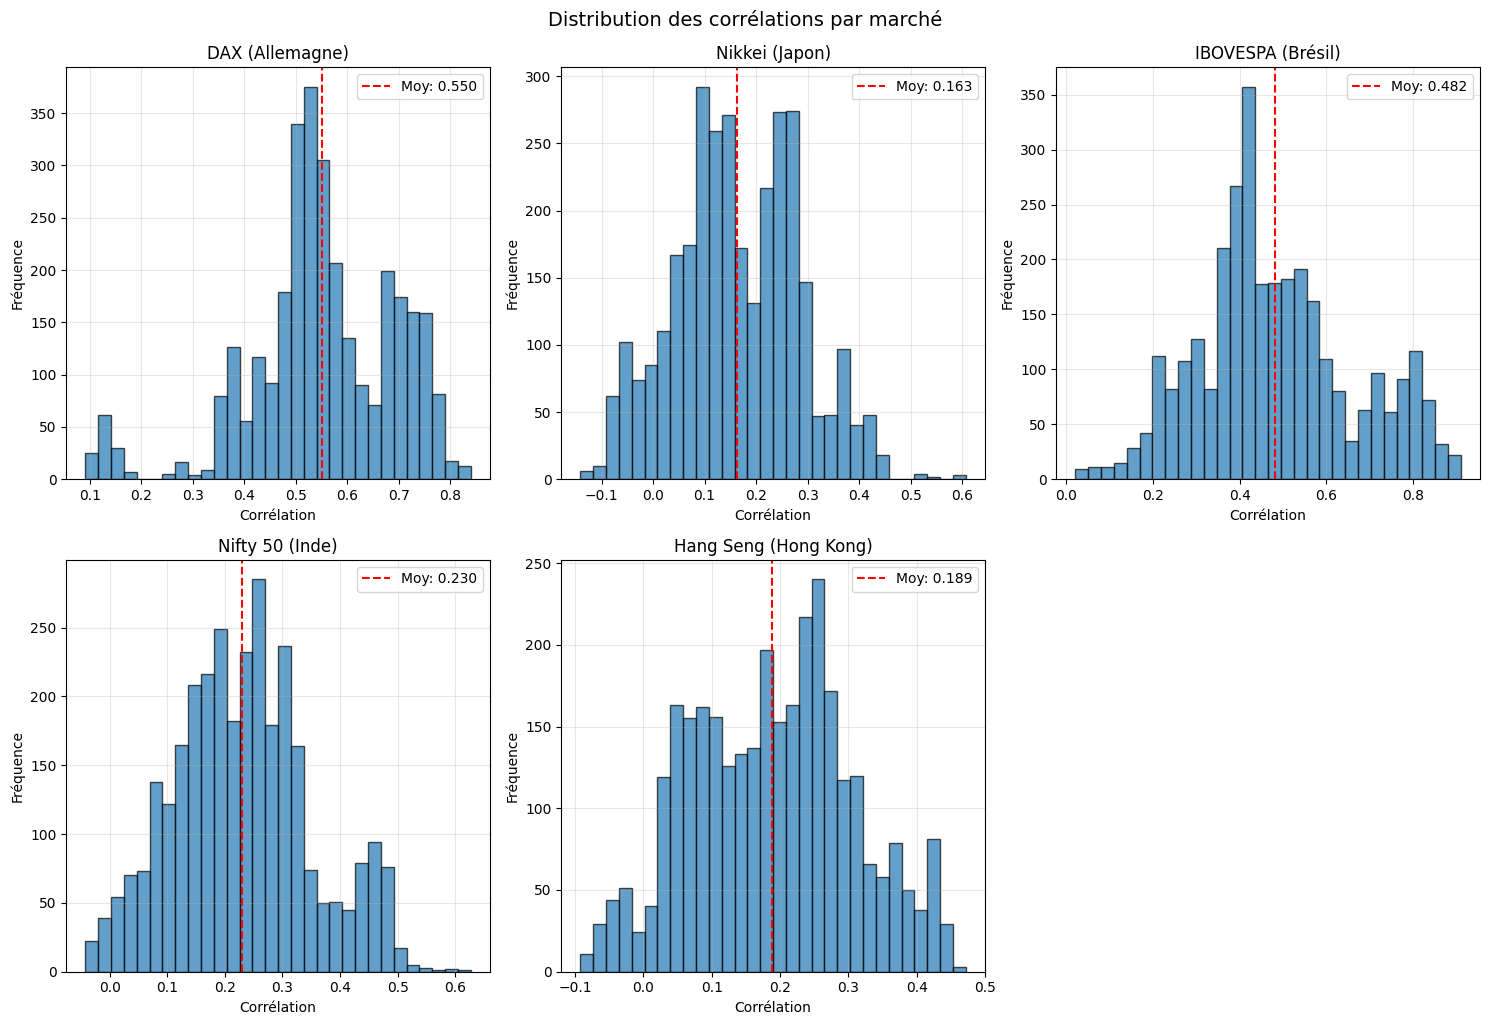


=== Volatilité des corrélations (écart-type) ===
IBOVESPA (Brésil)   : 0.179
DAX (Allemagne)     : 0.142
Nikkei (Japon)      : 0.121
Nifty 50 (Inde)     : 0.119
Hang Seng (Hong Kong): 0.118

=== Périodes de corrélations élevées (> 0.8) ===
DAX (Allemagne)     : 26 observations (>0.8)
IBOVESPA (Brésil)   : 156 observations (>0.8)


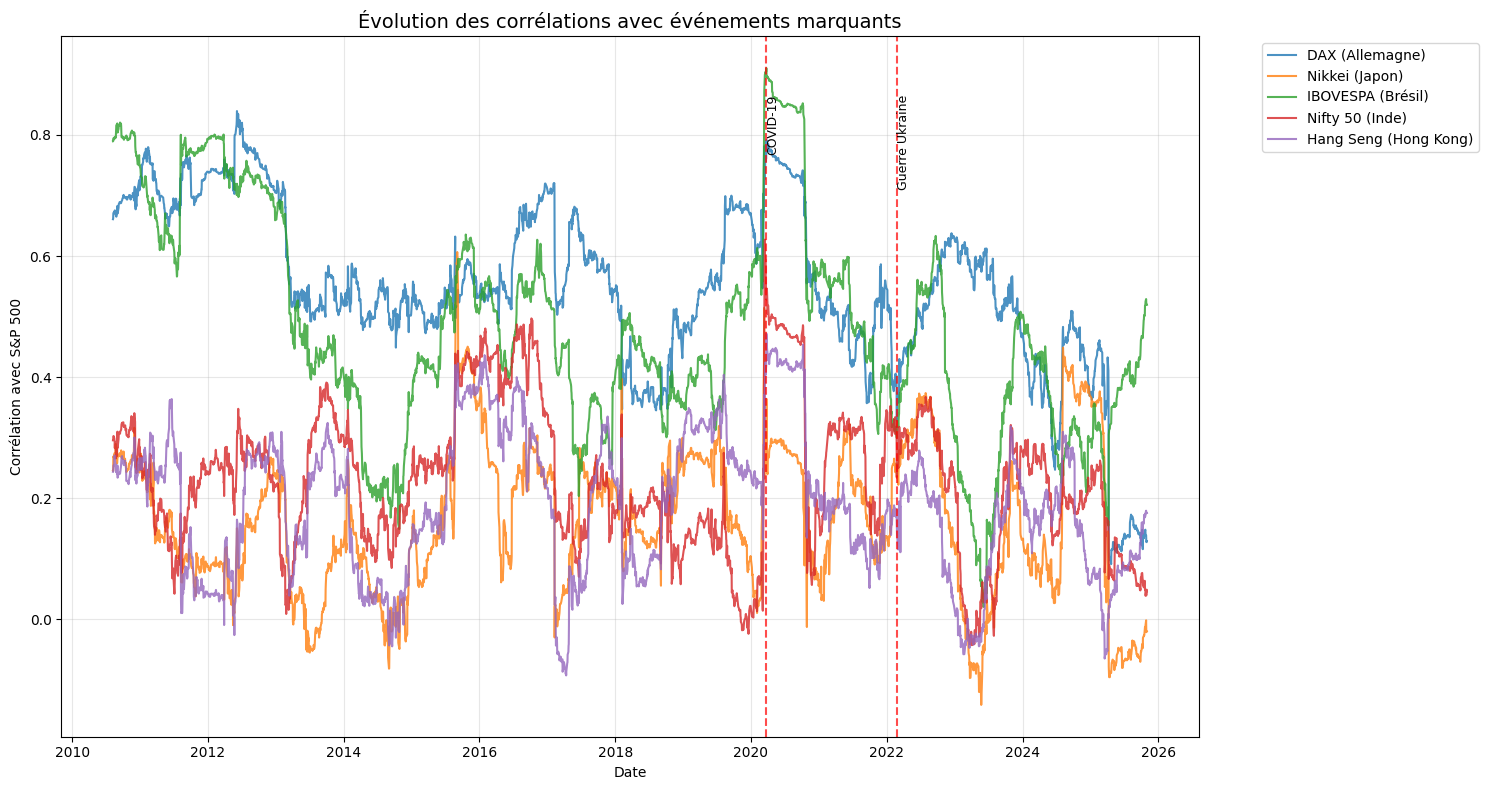


=== Corrélation entre les séries de corrélation ===


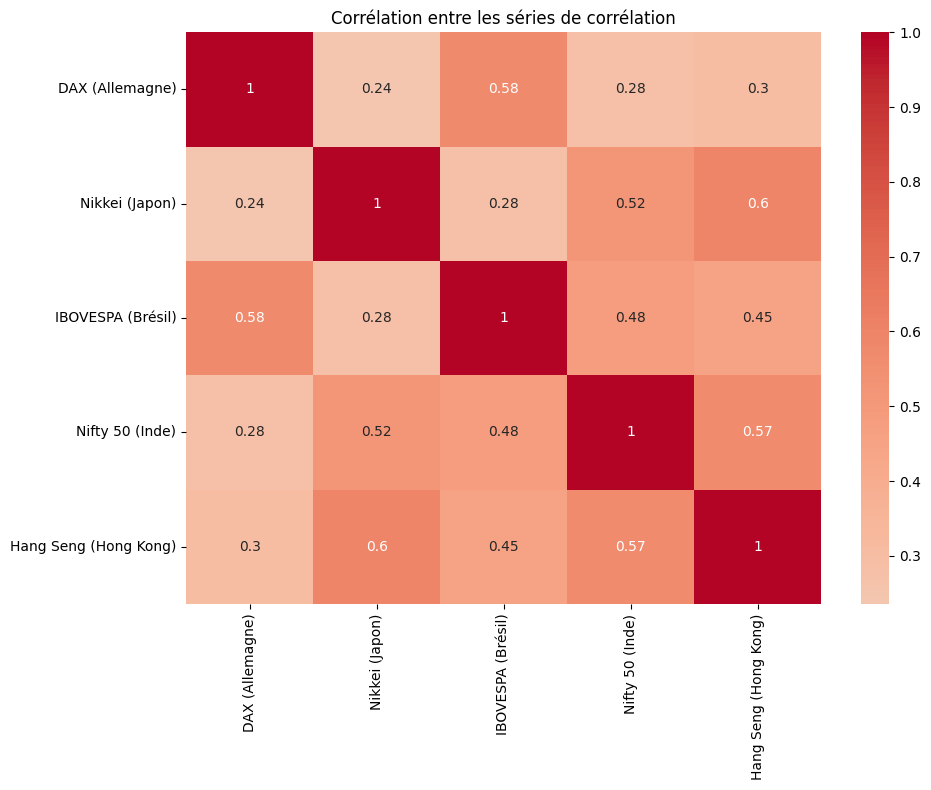


=== Comparaison pré/post 2020 ===
                       Pré_2020_Moyenne  Post_2020_Moyenne  \
DAX (Allemagne)                   0.591              0.484   
Nikkei (Japon)                    0.162              0.164   
IBOVESPA (Brésil)                 0.504              0.446   
Nifty 50 (Inde)                   0.233              0.227   
Hang Seng (Hong Kong)             0.198              0.174   

                       Pré_2020_Volatilité  Post_2020_Volatilité  
DAX (Allemagne)                      0.110                 0.161  
Nikkei (Japon)                       0.104                 0.144  
IBOVESPA (Brésil)                    0.166                 0.192  
Nifty 50 (Inde)                      0.109                 0.134  
Hang Seng (Hong Kong)                0.118                 0.117  

=== Synthèse pour section 2.1 ===
✓ Corrélations mobiles 126 jours calculées
✓ Tests de stationnarité robustes (ADF + PP + KPSS)
✓ Comparaison développés vs émergents
✓ Analyse visuelle et 

In [9]:
# 2.1.3 - Analyse descriptive et visuelle complémentaire
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Charger les corrélations pour analyse
corr_df = pd.read_csv(data_dir / 'correlations_126days.csv', index_col=0, parse_dates=True)

print("=== Analyse descriptive complémentaire ===")

# 1. Distribution des corrélations par marché
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

for i, col in enumerate(corr_df.columns):
    axes[i].hist(corr_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{markets.get(col, col)}')
    axes[i].set_xlabel('Corrélation')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(True, alpha=0.3)
    
    # Ajouter statistiques
    mean_corr = corr_df[col].mean()
    std_corr = corr_df[col].std()
    axes[i].axvline(mean_corr, color='red', linestyle='--', 
                   label=f'Moy: {mean_corr:.3f}')
    axes[i].legend()

# Supprimer le subplot vide
axes[5].remove()
plt.tight_layout()
plt.suptitle('Distribution des corrélations par marché', fontsize=14, y=1.02)
plt.show()

# 2. Volatilité des corrélations (mesure d'instabilité)
print("\n=== Volatilité des corrélations (écart-type) ===")
volatility_corr = corr_df.std().sort_values(ascending=False)
for market, vol in volatility_corr.items():
    print(f"{markets.get(market, market):20}: {vol:.3f}")

# 3. Analyse des périodes de crise (corrélations élevées)
print("\n=== Périodes de corrélations élevées (> 0.8) ===")
high_corr_periods = {}
for col in corr_df.columns:
    high_periods = corr_df[corr_df[col] > 0.8].index
    if len(high_periods) > 0:
        high_corr_periods[col] = len(high_periods)
        print(f"{markets.get(col, col):20}: {len(high_periods)} observations (>{0.8})")

# 4. Evolution temporelle avec événements marquants
fig, ax = plt.subplots(figsize=(15, 8))

# Tracer toutes les corrélations
for col in corr_df.columns:
    ax.plot(corr_df.index, corr_df[col], label=markets.get(col, col), linewidth=1.5, alpha=0.8)

# Ajouter des événements marquants
events = {
    '2008-09-15': 'Crise Lehman',
    '2020-03-23': 'COVID-19',
    '2022-02-24': 'Guerre Ukraine'
}

for date, event in events.items():
    try:
        event_date = pd.to_datetime(date)
        if corr_df.index[0] <= event_date <= corr_df.index[-1]:
            ax.axvline(event_date, color='red', linestyle='--', alpha=0.7)
            ax.text(event_date, ax.get_ylim()[1]*0.9, event, 
                   rotation=90, verticalalignment='top', fontsize=9)
    except:
        continue

ax.set_title('Évolution des corrélations avec événements marquants', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Corrélation avec S&P 500')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Matrice de corrélation entre les séries de corrélation
print("\n=== Corrélation entre les séries de corrélation ===")
corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            xticklabels=[markets.get(col, col) for col in corr_matrix.columns],
            yticklabels=[markets.get(col, col) for col in corr_matrix.columns])
plt.title('Corrélation entre les séries de corrélation')
plt.tight_layout()
plt.show()

# 6. Statistiques par période (pré/post 2020)
print("\n=== Comparaison pré/post 2020 ===")
pre_2020 = corr_df[corr_df.index < '2020-01-01']
post_2020 = corr_df[corr_df.index >= '2020-01-01']

comparison_stats = pd.DataFrame({
    'Pré_2020_Moyenne': pre_2020.mean(),
    'Post_2020_Moyenne': post_2020.mean(),
    'Pré_2020_Volatilité': pre_2020.std(),
    'Post_2020_Volatilité': post_2020.std()
})

comparison_stats.index = [markets.get(idx, idx) for idx in comparison_stats.index]
print(comparison_stats.round(3))

print("\n=== Synthèse pour section 2.1 ===")
print("✓ Corrélations mobiles 126 jours calculées")
print("✓ Tests de stationnarité robustes (ADF + PP + KPSS)")
print("✓ Comparaison développés vs émergents")
print("✓ Analyse visuelle et statistique complète")
print("→ Section 2.1 complète pour le rapport Word")